In [220]:
import os
import struct
import numpy as np
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np


from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap
import glob
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

__all__ = ["ColorMNIST"]

In [221]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

train_data = MNIST(root = '/Users/arpit/Desktop/GAN/MNIST_Dataset/', train=True, download=True, transform=transforms)
val_data = MNIST(root = '/Users/arpit/Desktop/GAN/MNIST_Dataset/', train=False, download=True, transform=transforms)

--2021-05-07 16:22:12--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-05-07 16:22:13--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [   <=>              ]  33.20M  1.22MB/s    in 1m 47s  

2021-05-07 16:24:01 (317 KB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-idx

In [224]:
class ColorMNIST(Dataset):
    def __init__(self, color, split, path, transform_list=[], randomcolor=False):
        assert color in ['num', 'back', 'both'], "color must be either 'num', 'back' or 'both"
        self.pallette = [[31, 119, 180],
                         [255, 127, 14],
                         [44, 160, 44],
                         [214, 39, 40],
                         [148, 103, 189],
                         [140, 86, 75],
                         [227, 119, 194],
                         [127, 127, 127],
                         [188, 189, 34],
                         [23, 190, 207]]

        if split == 'train':
            fimages = os.path.join(path, 'raw', 'train-images-idx3-ubyte')
            flabels = os.path.join(path, 'raw', 'train-labels-idx1-ubyte')
        else:
            fimages = os.path.join(path, 'raw', 't10k-images-idx3-ubyte')
            flabels = os.path.join(path, 'raw', 't10k-labels-idx1-ubyte')

        # Load images
        with open(fimages, 'rb') as f:
            _, _, rows, cols = struct.unpack(">IIII", f.read(16))
            self.images = np.fromfile(f, dtype=np.uint8).reshape(-1, rows, cols)

        # Load labels
        with open(flabels, 'rb') as f:
            struct.unpack(">II", f.read(8))
            self.labels = np.fromfile(f, dtype=np.int8)
            self.labels = torch.from_numpy(self.labels.astype(np.int))

        self.transform_list = transform_list
        self.color = color
        self.images = np.tile(self.images[:, :, :, np.newaxis], 3)
        self.randomcolor = randomcolor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Range [0,255]
        label = self.labels[idx]

        # Choose color
        if self.randomcolor:
            c = self.pallette[np.random.randint(0, 10)]
            if self.color == 'both':
                while True:
                    c2 = self.pallette[np.random.randint(0, 10)]
                    if c2 != c: break
        else:
            if self.color == 'num':
                c = self.pallette[-(label + 1)]
            elif self.color == 'back':
                c = self.pallette[label]
            else:
                c = self.pallette[label]
                c2 = self.pallette[-(label - 3)]

        # Assign color according to their class (0,10)
        if self.color == 'num':
            image[:, :, 0] = image[:, :, 0] / 255 * c[0]
            image[:, :, 1] = image[:, :, 1] / 255 * c[1]
            image[:, :, 2] = image[:, :, 2] / 255 * c[2]
        elif self.color == 'back':
            image[:, :, 0] = (255 - image[:, :, 0]) / 255 * c[0]
            image[:, :, 1] = (255 - image[:, :, 1]) / 255 * c[1]
            image[:, :, 2] = (255 - image[:, :, 2]) / 255 * c[2]
        else:
            image[:, :, 0] = image[:, :, 0] / 255 * c[0] + (255 - image[:, :, 0]) / 255 * c2[0]
            image[:, :, 1] = image[:, :, 1] / 255 * c[1] + (255 - image[:, :, 1]) / 255 * c2[1]
            image[:, :, 2] = image[:, :, 2] / 255 * c[2] + (255 - image[:, :, 2]) / 255 * c2[2]

        image = Image.fromarray(image)
        for t in self.transform_list:
            image = t(image)
        image = transforms.ToTensor()(image)  # Range [0,1]

        return image, label

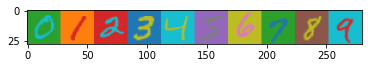

In [225]:
dataloader = ColorMNIST('both', 'train', '/Users/arpit/Desktop/GAN/MNIST_Dataset/MNIST/', randomcolor=True)

x_all = []
for i in [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]:
    x_all.append(dataloader[i][0].numpy().transpose([1, 2, 0]))
x_all = np.hstack(x_all)

plt.imshow(x_all)
plt.show()

In [226]:
#Reading Paintings
path = '/Users/arpit/Desktop/GAN/Paintings100/*.jpg'
filenames = [img for img in glob.glob(path)]
filenames.sort()
#Reading Generated Paintings
path_1 = '/Users/arpit/Desktop/GAN/GeneratedPaintiings100/*.png'
filenames_1 = [img for img in glob.glob(path_1)]
filenames_1.sort()
# Monet Palette
mp_palette = []
for name in filenames:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Monet Palette Dominant color is: BGR ({})'.format(centers[0].astype(np.int32)))
    mp_palette.append(centers[0].astype(np.int32))
    
#Generated Monet Palette
gen_palette = []
for name in filenames_1:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Generated Monet Palette Dominant color is: BGR({})'.format(centers[0].astype(np.int32)))
    gen_palette.append(centers[0].astype(np.int32))
rgb_pal = [i[[2,1,0]] for i in mp_palette]
X = [i/255 for i in rgb_pal]

In [227]:
newdata=list()
for line in rgb_pal:
    line = list(line)
    newdata.append(line)

In [228]:
class PaletteMNIST(Dataset):
    def __init__(self, color, split, path, transform_list=[], randomcolor=False):
        assert color in ['num', 'back', 'both'], "color must be either 'num', 'back' or 'both"
        self.pallette = newdata

        if split == 'train':
            fimages = os.path.join(path, 'raw', 'train-images-idx3-ubyte')
            flabels = os.path.join(path, 'raw', 'train-labels-idx1-ubyte')
        else:
            fimages = os.path.join(path, 'raw', 't10k-images-idx3-ubyte')
            flabels = os.path.join(path, 'raw', 't10k-labels-idx1-ubyte')

        # Load images
        with open(fimages, 'rb') as f:
            _, _, rows, cols = struct.unpack(">IIII", f.read(16))
            self.images = np.fromfile(f, dtype=np.uint8).reshape(-1, rows, cols)

        # Load labels
        with open(flabels, 'rb') as f:
            struct.unpack(">II", f.read(8))
            self.labels = np.fromfile(f, dtype=np.int8)
            self.labels = torch.from_numpy(self.labels.astype(np.int))

        self.transform_list = transform_list
        self.color = color
        self.images = np.tile(self.images[:, :, :, np.newaxis], 3)
        self.randomcolor = randomcolor

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Range [0,255]
        label = self.labels[idx]

        # Choose color
        if self.randomcolor:
            c = self.pallette[np.random.randint(0, 10)]
            if self.color == 'both':
                while True:
                    c2 = self.pallette[np.random.randint(0, 10)]
                    if c2 != c: break
        else:
            if self.color == 'num':
                c = self.pallette[-(label + 1)]
            elif self.color == 'back':
                c = self.pallette[label]
            else:
                c = self.pallette[label]
                c2 = self.pallette[-(label - 3)]

        # Assign color according to their class (0,10)
        if self.color == 'num':
            image[:, :, 0] = image[:, :, 0] / 255 * c[0]
            image[:, :, 1] = image[:, :, 1] / 255 * c[1]
            image[:, :, 2] = image[:, :, 2] / 255 * c[2]
        elif self.color == 'back':
            image[:, :, 0] = (255 - image[:, :, 0]) / 255 * c[0]
            image[:, :, 1] = (255 - image[:, :, 1]) / 255 * c[1]
            image[:, :, 2] = (255 - image[:, :, 2]) / 255 * c[2]
        else:
            image[:, :, 0] = image[:, :, 0] / 255 * c[0] + (255 - image[:, :, 0]) / 255 * c2[0]
            image[:, :, 1] = image[:, :, 1] / 255 * c[1] + (255 - image[:, :, 1]) / 255 * c2[1]
            image[:, :, 2] = image[:, :, 2] / 255 * c[2] + (255 - image[:, :, 2]) / 255 * c2[2]

        image = Image.fromarray(image)
        for t in self.transform_list:
            image = t(image)
        image = transforms.ToTensor()(image)  # Range [0,1]

        return image, label

In [229]:
dataloader = PaletteMNIST('both', 'train', '/Users/arpit/Desktop/GAN/MNIST_Dataset/MNIST/', randomcolor=True)

x_all = []
for i in range(60000):
    x_all.append(dataloader[i][0].numpy().transpose([1, 2, 0]))

#plt.imshow(x_all)
#plt.show()

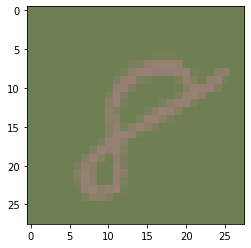

In [111]:
plt.imshow(x_all[59999])

In [138]:
x_all[0]

array([[[0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        ...,
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864]],

       [[0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        ...,
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864]],

       [[0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        ...,
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864]],

       ...,

       [[0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0.49803922, 0.32156864],
        [0.43137255, 0

In [232]:
for i in range(len(x_all)):
    plt.imsave('ColorMnist/img'+str(i)+'.png', x_all[i])

In [317]:
dataset = datasets.ImageFolder('MNISTnew', transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=100,
    shuffle=True
)

In [318]:
cuda = True if torch.cuda.is_available() else False

In [319]:
channels = 3
img_size = 28

In [320]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())

    def forward(self, img):
        #print('img',img.shape)
        out = self.model(img)
        #print("1",out.shape)
        out = out.view(out.shape[0], -1)
        #print("2",out.shape)
        validity = self.adv_layer(out)

        return validity

In [321]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [322]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [323]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5,0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [324]:
n_epochs = 200
latent_dim = 100

In [325]:
for epoch in range(n_epochs):
    for i, (imgs,_) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        
        save_image(gen_imgs.data[:25], "images-1/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/600] [D loss: 0.693366] [G loss: 0.714394]
[Epoch 0/200] [Batch 1/600] [D loss: 0.693379] [G loss: 0.713697]
[Epoch 0/200] [Batch 2/600] [D loss: 0.693389] [G loss: 0.713095]
[Epoch 0/200] [Batch 3/600] [D loss: 0.693327] [G loss: 0.712382]
[Epoch 0/200] [Batch 4/600] [D loss: 0.693316] [G loss: 0.711824]
[Epoch 0/200] [Batch 5/600] [D loss: 0.693274] [G loss: 0.711059]
[Epoch 0/200] [Batch 6/600] [D loss: 0.693311] [G loss: 0.710503]
[Epoch 0/200] [Batch 7/600] [D loss: 0.693303] [G loss: 0.709917]
[Epoch 0/200] [Batch 8/600] [D loss: 0.693260] [G loss: 0.709198]
[Epoch 0/200] [Batch 9/600] [D loss: 0.693316] [G loss: 0.708562]
[Epoch 0/200] [Batch 10/600] [D loss: 0.693288] [G loss: 0.707875]
[Epoch 0/200] [Batch 11/600] [D loss: 0.693250] [G loss: 0.707286]
[Epoch 0/200] [Batch 12/600] [D loss: 0.693247] [G loss: 0.706525]
[Epoch 0/200] [Batch 13/600] [D loss: 0.693294] [G loss: 0.705970]
[Epoch 0/200] [Batch 14/600] [D loss: 0.693249] [G loss: 0.705359]
[Epoc

[Epoch 0/200] [Batch 123/600] [D loss: 0.690201] [G loss: 0.696524]
[Epoch 0/200] [Batch 124/600] [D loss: 0.690800] [G loss: 0.696240]
[Epoch 0/200] [Batch 125/600] [D loss: 0.690434] [G loss: 0.696700]
[Epoch 0/200] [Batch 126/600] [D loss: 0.691258] [G loss: 0.694528]
[Epoch 0/200] [Batch 127/600] [D loss: 0.694313] [G loss: 0.688321]
[Epoch 0/200] [Batch 128/600] [D loss: 0.697947] [G loss: 0.682950]
[Epoch 0/200] [Batch 129/600] [D loss: 0.696964] [G loss: 0.683029]
[Epoch 0/200] [Batch 130/600] [D loss: 0.695282] [G loss: 0.687756]
[Epoch 0/200] [Batch 131/600] [D loss: 0.695567] [G loss: 0.688036]
[Epoch 0/200] [Batch 132/600] [D loss: 0.694076] [G loss: 0.690586]
[Epoch 0/200] [Batch 133/600] [D loss: 0.692070] [G loss: 0.693875]
[Epoch 0/200] [Batch 134/600] [D loss: 0.689744] [G loss: 0.698524]
[Epoch 0/200] [Batch 135/600] [D loss: 0.688573] [G loss: 0.699889]
[Epoch 0/200] [Batch 136/600] [D loss: 0.685988] [G loss: 0.702114]
[Epoch 0/200] [Batch 137/600] [D loss: 0.684896]

[Epoch 0/200] [Batch 244/600] [D loss: 0.694144] [G loss: 0.696132]
[Epoch 0/200] [Batch 245/600] [D loss: 0.694062] [G loss: 0.694887]
[Epoch 0/200] [Batch 246/600] [D loss: 0.693609] [G loss: 0.695582]
[Epoch 0/200] [Batch 247/600] [D loss: 0.693411] [G loss: 0.695001]
[Epoch 0/200] [Batch 248/600] [D loss: 0.693907] [G loss: 0.694418]
[Epoch 0/200] [Batch 249/600] [D loss: 0.693361] [G loss: 0.694307]
[Epoch 0/200] [Batch 250/600] [D loss: 0.693810] [G loss: 0.694659]
[Epoch 0/200] [Batch 251/600] [D loss: 0.693746] [G loss: 0.694580]
[Epoch 0/200] [Batch 252/600] [D loss: 0.693804] [G loss: 0.694092]
[Epoch 0/200] [Batch 253/600] [D loss: 0.693289] [G loss: 0.694054]
[Epoch 0/200] [Batch 254/600] [D loss: 0.693102] [G loss: 0.693624]
[Epoch 0/200] [Batch 255/600] [D loss: 0.693521] [G loss: 0.694337]
[Epoch 0/200] [Batch 256/600] [D loss: 0.693449] [G loss: 0.694050]
[Epoch 0/200] [Batch 257/600] [D loss: 0.693408] [G loss: 0.694574]
[Epoch 0/200] [Batch 258/600] [D loss: 0.693604]

[Epoch 0/200] [Batch 365/600] [D loss: 0.688662] [G loss: 0.703621]
[Epoch 0/200] [Batch 366/600] [D loss: 0.687236] [G loss: 0.705937]
[Epoch 0/200] [Batch 367/600] [D loss: 0.687772] [G loss: 0.701269]
[Epoch 0/200] [Batch 368/600] [D loss: 0.688499] [G loss: 0.700335]
[Epoch 0/200] [Batch 369/600] [D loss: 0.693685] [G loss: 0.693836]
[Epoch 0/200] [Batch 370/600] [D loss: 0.691179] [G loss: 0.693628]
[Epoch 0/200] [Batch 371/600] [D loss: 0.695910] [G loss: 0.688107]
[Epoch 0/200] [Batch 372/600] [D loss: 0.694172] [G loss: 0.686754]
[Epoch 0/200] [Batch 373/600] [D loss: 0.694417] [G loss: 0.687345]
[Epoch 0/200] [Batch 374/600] [D loss: 0.691179] [G loss: 0.688045]
[Epoch 0/200] [Batch 375/600] [D loss: 0.690243] [G loss: 0.693321]
[Epoch 0/200] [Batch 376/600] [D loss: 0.688634] [G loss: 0.694319]
[Epoch 0/200] [Batch 377/600] [D loss: 0.685554] [G loss: 0.697927]
[Epoch 0/200] [Batch 378/600] [D loss: 0.687112] [G loss: 0.696127]
[Epoch 0/200] [Batch 379/600] [D loss: 0.691515]

KeyboardInterrupt: 